# İş Problemi

Maaş bilgileri ve 1986 yılına ait kariyer istatistikleri paylaşılan beyzbol
oyuncularının maaş tahminleri için bir makine öğrenmesi modeli geliştiriniz.

# Veri Seti Hikayesi

Bu veri seti orijinal olarak Carnegie Mellon Üniversitesi'nde bulunan
StatLib kütüphanesinden alınmıştır. Veri seti 1988 ASA Grafik Bölümü
Poster Oturumu'nda kullanılan verilerin bir parçasıdır. Maaş verileri
orijinal olarak Sports Illustrated, 20 Nisan 1987'den alınmıştır. 1986 ve
kariyer istatistikleri, Collier Books, Macmillan Publishing Company,
New York tarafından yayınlanan 1987 Beyzbol Ansiklopedisi
Güncellemesinden elde edilmiştir.

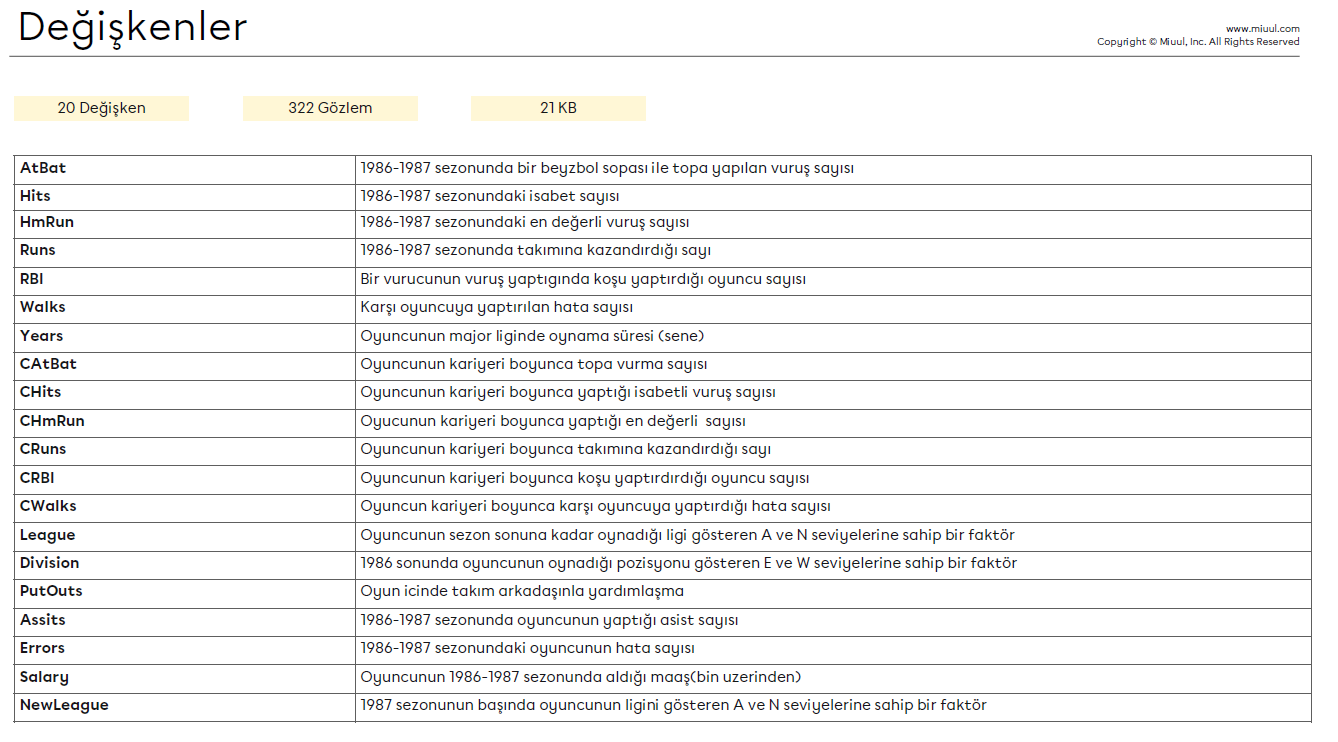

In [1]:
############################################
# Gerekli Kütüphane ve Fonksiyonlar
############################################

import warnings
import pandas as pd
import missingno as msno
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler

#from helpers.data_prep import * 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name, q1=.25, q3=.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe



def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

#from helpers.eda import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_csv(string):
    return pd.read_csv(string)

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T, end="\n\n")

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()



def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")



def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

def target_correlation_matrix(dataframe, corr_th=0.5, target="Salary"):
    """
    Bağımlı değişken ile verilen threshold değerinin üzerindeki korelasyona sahip değişkenleri getirir.
    :param dataframe:
    :param corr_th: eşik değeri
    :param target:  bağımlı değişken ismi
    :return:
    """
    corr = dataframe.corr()
    corr_th = corr_th
    try:
        filter = np.abs(corr[target]) > corr_th
        corr_features = corr.columns[filter].tolist()
        sns.clustermap(dataframe[corr_features].corr(), annot=True, fmt=".2f")
        plt.show()
        return corr_features
    except:
        print("Yüksek threshold değeri, corr_th değerinizi düşürün!")
        
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Tum Base Modeller
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df = pd.read_csv(r"C:\Users\ceren\Desktop\miuul\machine_learning\Maas_Tahmin_Modeli\beyzbol maaş tahmini çözüm\hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


In [3]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
AtBat,322.000,380.929,153.405,16.000,20.420,161.000,379.500,512.000,584.900,658.590,687.000
Hits,322.000,101.025,46.455,1.000,4.420,39.000,96.000,137.000,163.000,210.790,238.000
HmRun,322.000,10.770,8.709,0.000,0.000,0.000,8.000,16.000,24.000,33.000,40.000
Runs,322.000,50.910,26.024,0.000,1.210,17.000,48.000,69.000,89.000,107.790,130.000
RBI,322.000,48.028,26.167,0.000,2.000,14.000,44.000,64.750,86.000,112.370,121.000
Walks,322.000,38.742,21.639,0.000,1.000,11.050,35.000,53.000,69.900,93.580,105.000
Years,322.000,7.444,4.926,1.000,1.000,1.000,6.000,11.000,15.000,19.790,24.000
CAtBat,322.000,2648.683,2324.206,19.000,41.000,216.500,1928.000,3924.250,6123.400,8749.970,14053.000
CHits,322.000,717.571,654.473,4.000,9.840,54.000,508.000,1059.250,1659.600,2500.340,4256.000
CHmRun,322.000,69.491,86.266,0.000,0.000,2.000,37.500,90.000,194.900,373.120,548.000


In [4]:
check_df(df)


##################### Shape #####################
(322, 20)
##################### Types #####################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
##################### Head #####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        

Salary değişkeni bağımlı değişkenimizdir 59 kayıp değere sahiptir. Bağımlı değişkene müdahale etmeyi sevmeyiz.

* CAtBat, CHits outlier olabilir.


In [5]:
# BAĞIMLI DEĞİŞKEN ANALİZİ
import seaborn as sns
import matplotlib.pyplot as plt

df["Salary"].describe()

count    263.000
mean     535.926
std      451.119
min       67.500
25%      190.000
50%      425.000
75%      750.000
max     2460.000
Name: Salary, dtype: float64

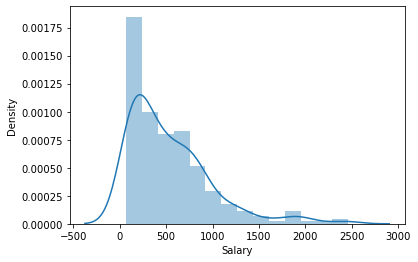

In [6]:
sns.distplot(df.Salary)
plt.show()


Sağa çarpık bir grafik karşımızda dağılımını normalleştirmek için logaritmik dönüşümü , minmax dönüşümü karekök dönüşümü yöntemleri işe yarar.

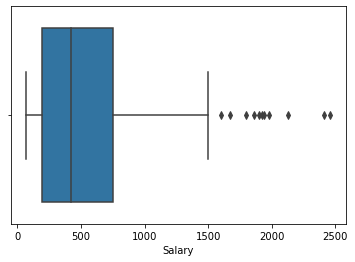

In [7]:

sns.boxplot(df["Salary"])
plt.show()


In [8]:
 # KATEGORİK VE NUMERİK DEĞİŞKENLERİN SEÇİLMESİ

cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'Salary']

In [9]:
cat_cols

['League', 'Division', 'NewLeague']

In [10]:
# KATEGORİK DEĞİŞKEN ANALİZİ

rare_analyser(df, "Salary", cat_cols)

League : 2
   COUNT  RATIO  TARGET_MEAN
A    175  0.543      542.000
N    147  0.457      529.117


Division : 2
   COUNT  RATIO  TARGET_MEAN
E    157  0.488      624.271
W    165  0.512      450.877


NewLeague : 2
   COUNT  RATIO  TARGET_MEAN
A    176  0.547      537.113
N    146  0.453      534.554




In [11]:
# SAYISAL DEĞİŞKEN ANALİZİ

for col in num_cols:
    num_summary(df, col, plot=False)



count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64

count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64

count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64

count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
20

In [12]:
# AYKIRI GÖZLEM ANALİZİ
for col in num_cols:
    print(col, check_outlier(df, col, q1=0.1, q3=0.9))



AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits True
CHmRun True
CRuns False
CRBI False
CWalks True
PutOuts False
Assists False
Errors False
Salary False


Chits ve Cwalks outlier değerlere sahip

In [13]:
# 1300 den sonraki değerleri veri setinden çıkartıyorum.

print(df.shape)
df = df[(df['Salary'] < 1350) | (df['Salary'].isnull())]  # Eksik değerleri de istiyoruz.
print(df.shape)


(322, 20)
(308, 20)


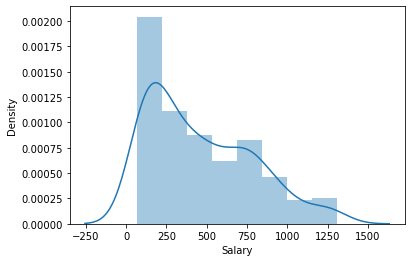

In [14]:
sns.distplot(df.Salary)
plt.show()

In [15]:
# AYKIRI DEĞERLERİ BASKILAMA
for col in num_cols:
    if check_outlier(df, col, q1=0.05, q3=0.95):
        replace_with_thresholds(df, col, q1=0.05, q3=0.95)

for col in num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


In [16]:
# EKSİK GÖZLEM ANALİZİ

missing_values_table(df)

        n_miss  ratio
Salary      59 19.160


Salary bağımlı değişkeninde 59 Eksik Gözlem bulunmakta. Bunları çıkartmak bir çözüm yolu olabilir. Doldurmak veya etiketlemek tercih edilmez.

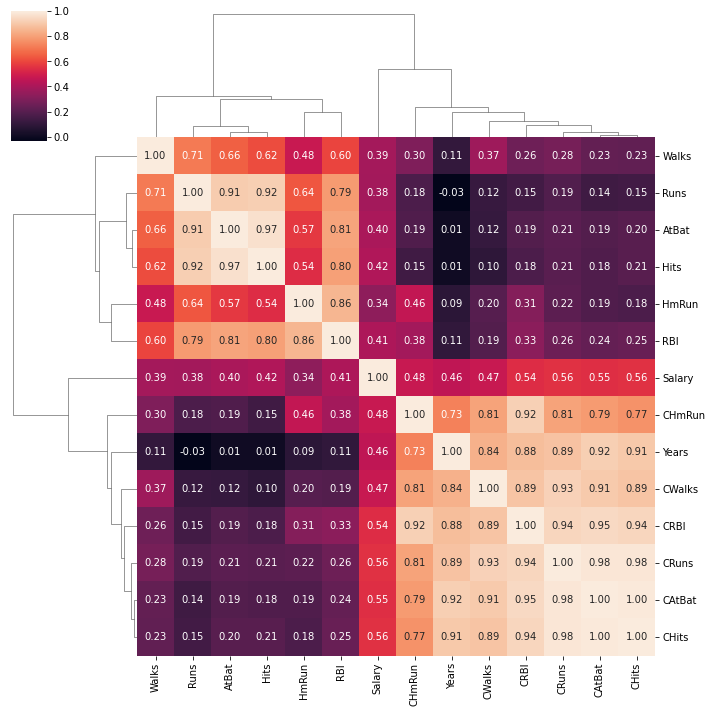

<ipython-input-1-cdf4977501c7>:226: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))


['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

In [17]:
# KORELASYON ANALİZİ

import numpy as np

target_correlation_matrix(df, corr_th=0.3, target="Salary")
high_correlated_cols(df, plot=False, corr_th=0.90)

%75 ve üzerisi yüksek korelasyon

In [18]:
############################################
# VERİ ÖNİŞLEME
############################################

df['NEW_HitRatio'] = df['Hits'] / df['AtBat']
df['NEW_RunRatio'] = df['HmRun'] / df['Runs']
df['NEW_CHitRatio'] = df['CHits'] / df['CAtBat']
df['NEW_CRunRatio'] = df['CHmRun'] / df['CRuns']

df['NEW_Avg_AtBat'] = df['CAtBat'] / df['Years']
df['NEW_Avg_Hits'] = df['CHits'] / df['Years']
df['NEW_Avg_HmRun'] = df['CHmRun'] / df['Years']
df['NEW_Avg_Runs'] = df['CRuns'] / df['Years']
df['NEW_Avg_RBI'] = df['CRBI'] / df['Years']
df['NEW_Avg_Walks'] = df['CWalks'] / df['Years']

# Paydaya sıfır gelme ihtimaline karşılık paydadaki değişkenlere 1 eklenebilir.



In [19]:
# One Hot Encoder

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [20]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_HitRatio,NEW_RunRatio,NEW_CHitRatio,NEW_CRunRatio,NEW_Avg_AtBat,NEW_Avg_Hits,NEW_Avg_HmRun,NEW_Avg_Runs,NEW_Avg_RBI,NEW_Avg_Walks,League_N,Division_W,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20,NaN,0.225,0.033,0.225,0.033,293.000,66.000,1.000,30.000,29.000,14.000,0,0,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.000,0.257,0.292,0.242,0.215,246.357,59.643,4.929,22.929,29.571,26.786,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.000,0.271,0.273,0.281,0.281,541.333,152.333,21.000,74.667,88.667,87.667,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.000,0.284,0.308,0.280,0.272,511.636,143.182,20.455,75.273,76.182,32.182,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.500,0.271,0.256,0.255,0.250,198.000,50.500,6.000,24.000,23.000,16.500,1,0,1


In [21]:
############################################
# MODELLEME
############################################

df_null = df[df["Salary"].isnull()]  # Salary içerisindeki boş değerleri ayıralım.
df.dropna(inplace=True)  # Salarydeki eksik değerleri çıkartma

y = df['Salary']
X = df.drop("Salary", axis=1)


In [22]:
X.iloc[0,:]

AtBat           315.000
Hits             81.000
HmRun             7.000
Runs             24.000
RBI              38.000
                  ...  
NEW_Avg_RBI      29.571
NEW_Avg_Walks    26.786
League_N          1.000
Division_W        1.000
NewLeague_N       1.000
Name: 1, Length: 29, dtype: float64

In [23]:
y[1]

475.0

In [29]:
##########################
# HOLD OUT - MODEL VALIDATION
##########################


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [ ]:
##########################
# # ROBUST SCALER:
# ALL DATA FINAL RMSE: 219.83899058361285
##########################

# cols = X.columns
# index = X.index
# from sklearn.preprocessing import RobustScaler
# transformer = RobustScaler().fit(X)
# X = transformer.transform(X)
# X = pd.DataFrame(X, columns=cols, index=index)

##########################
# # STANDARD SCALER:
# ALL DATA FINAL RMSE: 186.16240421879607
##########################

# num_cols.remove("Salary")
# scaler = StandardScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])


In [30]:
def all_models(X, y, test_size=0.2, random_state=12345, classification=True):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
        roc_auc_score, confusion_matrix, classification_report, plot_roc_curve, mean_squared_error

    # Tum Base Modeller (Classification)
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from catboost import CatBoostClassifier
    from lightgbm import LGBMClassifier
    from sklearn.svm import SVC

    # Tum Base Modeller (Regression)
    from catboost import CatBoostRegressor
    from lightgbm import LGBMRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.svm import SVR
    from sklearn.tree import DecisionTreeRegressor
    from xgboost import XGBRegressor

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)
    all_models = []

    if classification:
        models = [('LR', LogisticRegression(random_state=random_state)),
                  ('KNN', KNeighborsClassifier()),
                  ('CART', DecisionTreeClassifier(random_state=random_state)),
                  ('RF', RandomForestClassifier(random_state=random_state)),
                  ('SVM', SVC(gamma='auto', random_state=random_state)),
                  ('XGB', GradientBoostingClassifier(random_state=random_state)),
                  ("LightGBM", LGBMClassifier(random_state=random_state)),
                  ("CatBoost", CatBoostClassifier(verbose=False, random_state=random_state))]

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            acc_train = accuracy_score(y_train, y_pred_train)
            acc_test = accuracy_score(y_test, y_pred_test)
            values = dict(name=name, acc_train=acc_train, acc_test=acc_test)
            all_models.append(values)

        sort_method = False
    else:
        models = [('LR', LinearRegression()),
                  ("Ridge", Ridge()),
                  ("Lasso", Lasso()),
                  ("ElasticNet", ElasticNet()),
                  ('KNN', KNeighborsRegressor()),
                  ('CART', DecisionTreeRegressor()),
                  ('RF', RandomForestRegressor()),
                  ('SVR', SVR()),
                  ('GBM', GradientBoostingRegressor()),
                  ("XGBoost", XGBRegressor()),
                  ("LightGBM", LGBMRegressor()),
                  ("CatBoost", CatBoostRegressor(verbose=False))]

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            values = dict(name=name, RMSE_TRAIN=rmse_train, RMSE_TEST=rmse_test)
            all_models.append(values)

        sort_method = True
    all_models_df = pd.DataFrame(all_models)
    all_models_df = all_models_df.sort_values(all_models_df.columns[2], ascending=sort_method)
    print(all_models_df)
    return all_models_df


all_models = all_models(X, y, test_size=0.2, random_state=46, classification=False)


          name  RMSE_TRAIN  RMSE_TEST
11    CatBoost       4.970    237.712
9      XGBoost       0.001    256.239
6           RF      61.122    257.964
10    LightGBM      51.394    259.164
8          GBM      30.648    264.461
4          KNN     167.550    268.997
5         CART       0.000    310.186
3   ElasticNet     202.308    328.042
2        Lasso     200.520    332.650
1        Ridge     199.917    333.875
7          SVR     315.167    336.098
0           LR     198.591    336.352


* Catboost'da overfit olmuş

* XGboost'da overfit olmuş ............

* Ağaç tabanlı modellerden ilerleme daha avantajlı; hızlı ve parametre değiştirildiğinde optimum sonuca gidilebiliyor.

* Örneğin train ve test hatası birbirine yakın overfit olmamış fakat değer 300 olduğunda değerleri yanlış tahmin etmiş oluyoruz.

In [31]:
##########################
# RANDOM FORESTS MODEL TUNING
##########################

# Tuning için hazırlanan parametreler. Tuning zaman aldığı için çıkan parametre değerlerini girdim.
rf_params = {"max_depth": [4, 5, 7, 10], #ağaç dalları falan..
             "max_features": [4, 5, 6, 8, 10, 12],
             "n_estimators": [80, 100, 150, 250, 400, 500],
             "min_samples_split": [8, 10, 12, 15]}

# rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs = -1).fit(X_train , y_train) #verdiğimiz parametreleri deneyerek hangisinin optimum parametre sonucu olduğunu gösterir. 
# rf_cv_model.best_params_
#sonuc olarak bunları veriyor
best_params = {'max_depth': 10,
               'max_features': 8,
               'min_samples_split': 10,
               'n_estimators': 80}

rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)

In [39]:
# RANDOM FORESTS TUNED MODEL
rf_tuned = RandomForestRegressor(max_depth=10, max_features=8, n_estimators=80,
                                 min_samples_split=10, random_state=42).fit(X_train, y_train)

In [40]:
# TUNED MODEL TRAIN HATASI
y_pred = rf_tuned.predict(X_train)

print("RF Tuned Model Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

RF Tuned Model Train RMSE: 106.36720246290594


In [41]:
# TUNED MODEL TEST HATASI
##########################

y_pred = rf_tuned.predict(X_test)
print("RF Tuned Model Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

RF Tuned Model Test RMSE: 156.2255503788663


Amaçlarımızdan biri de test ve train arasındaki farkı azaltmak.

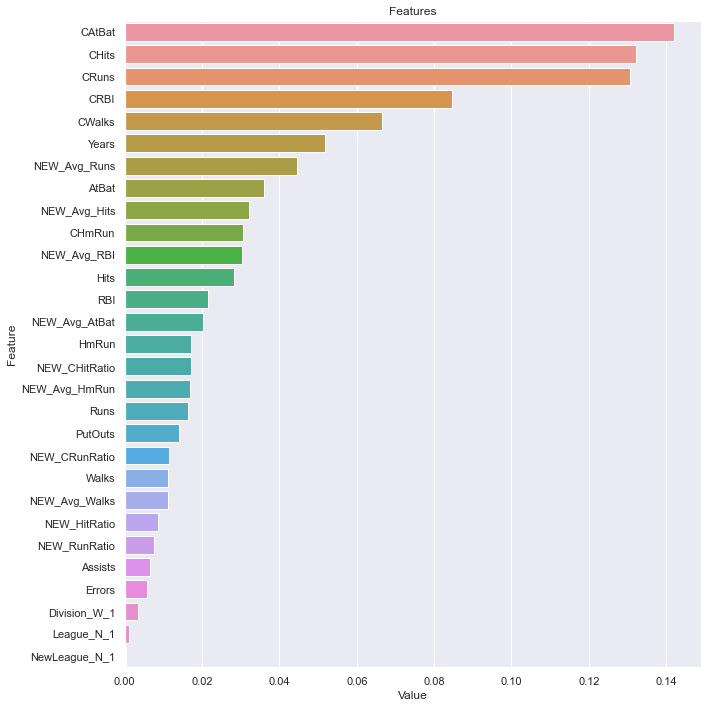

In [42]:
#######################################
# FEATURE IMPORTANCE
#######################################

def plot_importance(model, features, num=len(X), save=False):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_tuned, X_train)

Bu grafiğe bizim eklediğimiz featurelar geliyorsa mantıklı şeyler yapmışızdır.

In [43]:
# Tuned edilmiş model nesnesinin kaydedilmesi
import pickle
pickle.dump(rf_tuned, open("rf_final_model.pkl", 'wb'))


Uzun süre sonra modele ihtşyaç duyulduğunda çalıştırmadan tahmin edebiliriz.

In [44]:
# Tuned edilmiş model nesnesinin yüklenmesi
df_prep = pickle.load(open('rf_final_model.pkl', 'rb'))
df_prep

RandomForestRegressor(max_depth=10, max_features=8, min_samples_split=10,
                      n_estimators=80, random_state=42)